In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.
ds_train,ds_info = tfds.load('cats_vs_dogs',split= 'train', with_info=True)
ds_train = tfds.load('cats_vs_dogs',split= 'train[:80%]',as_supervised=True)
ds_test =  tfds.load('cats_vs_dogs',split= 'train[80%:]',as_supervised=True)

In [4]:
ds_info.features["label"].num_classes
ds_info.features["label"].names

['cat', 'dog']

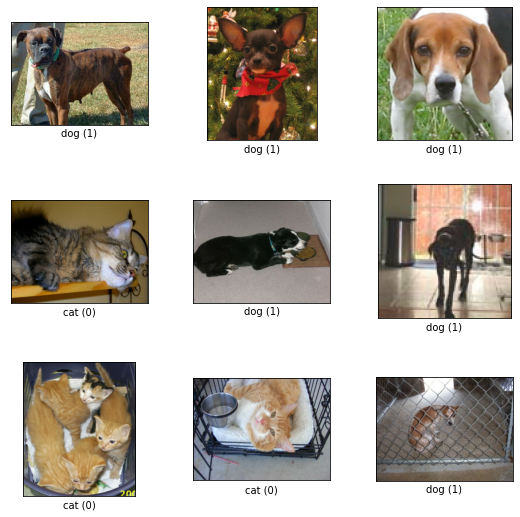

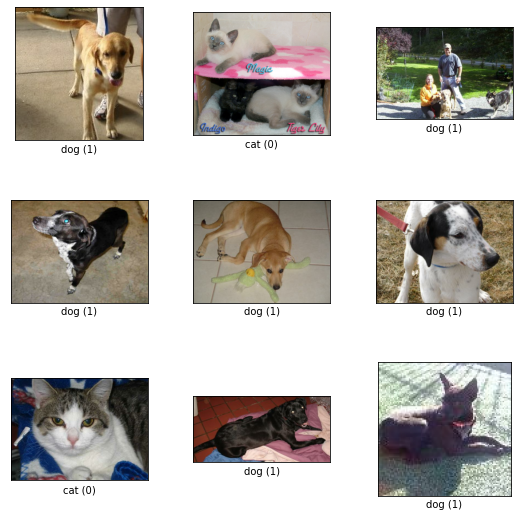

In [5]:
fig = tfds.show_examples(ds_train, ds_info)
fig = tfds.show_examples(ds_test, ds_info)

In [6]:
def normalize_and_resize_img(data,y):
    """Normalizes images: `uint8` -> `float32`."""
    # x = data['image']
    # y = data['label']
    data = tf.cast(data,tf.float32)/255.
    image = tf.image.resize(data, [224, 224])
    return image, y

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img,num_parallel_calls=1).batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_train = apply_normalize_on_dataset(ds_train,batch_size=16)
ds_test = apply_normalize_on_dataset(ds_test,batch_size=16)


In [9]:
ds_train

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [9]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
def conv_block_50(num,init_size,x,name,plain = False,First = False):
    for i in range(0,num):
        # print(i)
        if First == True and i == 0:
            short = x
            x = Conv2D(filters= init_size,
                        kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_1')(x)
        elif i == 0:
            short = x
            x = Conv2D(filters= init_size,strides=2,padding='same',
                        kernel_size=(1,1),name=f'stage{name}_{i+1}_1')(x)
            # short = Conv2D(filters= init_size,strides=2,padding='same',
            #             kernel_size=(3,3),name=f'stage{name}_{i+1}_1_short')(short)
        else:
            x = Conv2D(filters= init_size,
                        kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_1')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        x = Conv2D(filters= init_size,
                    kernel_size=(3,3),padding='same',name=f'stage{name}_{i+1}_2')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)           
        x = Conv2D(filters= init_size*4,
                    kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_3')(x)
        x = BatchNormalization()(x)
        if First == True and i == 0:
            short = Conv2D(filters= init_size*4,
                        kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_short')(short)        
            short = BatchNormalization()(short)
        elif i == 0:
            short = Conv2D(filters= init_size*4,strides=2,
                        kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_short')(short)        
            short = BatchNormalization()(short)
        if plain != True:
            x = keras.layers.Add()([x,short])
        x = Activation(activation='relu')(x)
        # print(i)
        short = x
    return x

def conv_block_34(num,init_size,x,name,plain = False,First = False):
    for i in range(0,num):
        if First == True and i == 0:
            short = x
            x = Conv2D(filters= init_size,
                        kernel_size=(3,3),padding='same',name=f'stage{name}_{i+1}_1')(x)
        elif i == 0:
            short = x    
            x = Conv2D(filters= init_size,strides=2,padding='same',
                        kernel_size=(3,3),name=f'stage{name}_{i+1}_1')(x)
        else:
            x = Conv2D(filters= init_size,
                        kernel_size=(3,3),padding='same',name=f'stage{name}_{i+1}_1')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)           
        x = Conv2D(filters= init_size,
                    kernel_size=(3,3),padding='same',name=f'stage{name}_{i+1}_2')(x)
        x = BatchNormalization()(x)
        if First == True and i == 0:
            pass
            # short = Conv2D(filters= init_size,
            #             kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_short')(short)        
            # short = BatchNormalization()(short)
        elif i == 0:
            short = Conv2D(filters= init_size,strides=2,
                        kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_short')(short)        
            short = BatchNormalization()(short)
        if plain != True:
            x = keras.layers.Add()([x,short])
        x = Activation(activation='relu')(x)
        short = x
    return x

# a = build_resnet(is_50 = False)
# a.summary()

In [10]:
def build_resnet(input_shape=(32,32,3), is_50 = True,plain =False):
    Input_layer = keras.layers.Input(shape=input_shape)
    x = Conv2D(filters=64,kernel_size=(7,7),strides=2,padding= 'same')(Input_layer)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    x = MaxPool2D((3,3),strides=2,padding= 'same')(x)

    if is_50 == True:
        x = conv_block_50(3,64,x,2,plain = plain,First= True)
        # x = Conv2D(128,(1,1),strides=2,padding='same')(x)
        x = conv_block_50(4,128,x,3,plain = plain)
        # x = Conv2D(256,(1,1),strides=2,padding='same')(x)
        x = conv_block_50(6,256,x,4,plain = plain)
        # x = Conv2D(512,(1,1),strides=2,padding='same')(x)
        x = conv_block_50(3,512,x,5,plain = plain)
        x = keras.layers.AveragePooling2D(pool_size=(1,1))(x)
        x = keras.layers.Flatten()(x)
        # x = keras.layers.Dense(1000, activation='relu', name='fc')(x)
        x = keras.layers.Dense(2, activation='softmax')(x)
    else:
        x = conv_block_34(3,64,x,2,plain = plain,First = True)
        # x = Conv2D(128,(3,3),strides=2,padding='same')(x)
        x = conv_block_34(4,128,x,3,plain = plain)
        # x = Conv2D(256,(3,3),strides=2,padding='same')(x)
        x = conv_block_34(6,256,x,4,plain = plain)
        # x = Conv2D(512,(3,3),strides=2,padding='same')(x)
        x = conv_block_34(3,512,x,5,plain = plain)
        x = keras.layers.AveragePooling2D(pool_size=(1,1))(x)
        x = keras.layers.Flatten()(x)
        # x = keras.layers.Dense(1000, activation='relu', name='fc')(x)
        x = keras.layers.Dense(2, activation='softmax')(x)        
    model = keras.Model(inputs=Input_layer,outputs=x)
    return model

In [11]:
# input_shape = (224,224,3)
# Input_layer = keras.layers.Input(shape=input_shape)
# testx = Conv2D(filters=64,kernel_size=(7,7),strides=2,padding= 'same')(Input_layer)
# testx = BatchNormalization()(testx)
# testx = Activation(activation='relu')(testx)
# testx = MaxPool2D((3,3),strides=2,padding= 'same')(testx)
# x = conv_block_34(3,64,testx,2,First= True)
# x = conv_block_34(4,128,x,3)
# tesmodel = keras.Model(inputs=Input_layer,outputs=x)


In [12]:
# tesmodel.summary()

In [13]:
# input_shape = (224,224,3)
# Input_layer = keras.layers.Input(shape=input_shape)
# testx = Conv2D(filters=64,kernel_size=(7,7),strides=2,padding= 'same')(Input_layer)
# testx = BatchNormalization()(testx)
# testx = Activation(activation='relu')(testx)
# testx = MaxPool2D((3,3),strides=2,padding= 'same')(testx)
# # testx = Conv2D(64,(1,1),strides=2,padding='same')(testx)
# test= conv_block_50(3,64,testx,2,plain=False,First= True)
# # test = Conv2D(128,(3,3),strides=2,padding='same')(test)
# test = conv_block_50(4,128,test,3)
# temodel = keras.Model(inputs=Input_layer,outputs=test)

In [14]:
# temodel.summary()

In [15]:
# temodel.summary()
# tf.keras.utils.plot_model(temodel, show_shapes=True, dpi=64)

In [11]:
# resnet30 = build_resnet(input_shape= (224,224,3),is_50 = False)
# resnet30_plain = build_resnet(input_shape= (224,224,3),is_50 = False,plain= True)
# resnet30.summary()
resnet50 = build_resnet(input_shape= (224,224,3))
resnet50_plain = build_resnet(input_shape= (224,224,3),plain= True)
# resnet50.summary()

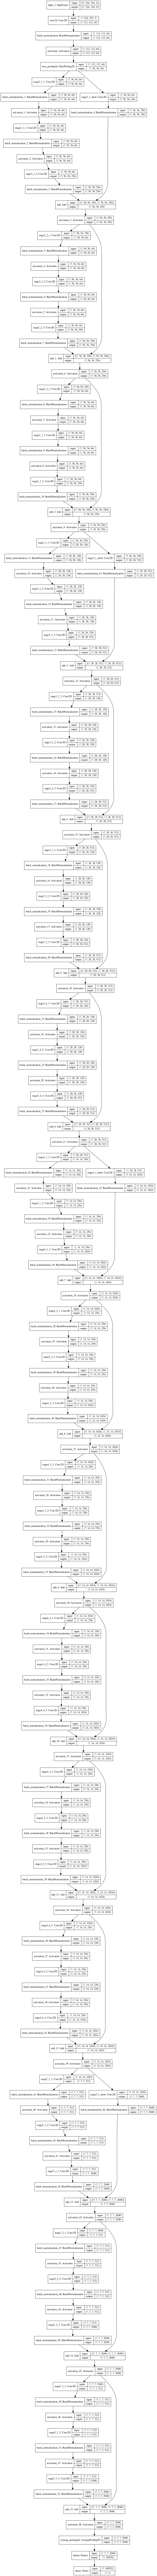

In [31]:
# resnet50.summary()
tf.keras.utils.plot_model(resnet50, show_shapes=True, dpi=64)

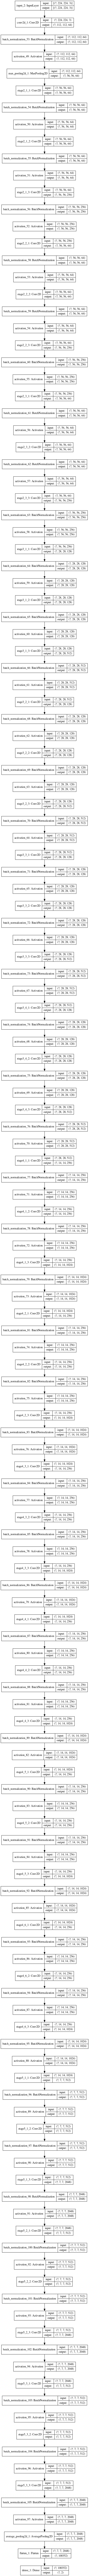

In [32]:
# resnet50_plain.summary()
tf.keras.utils.plot_model(resnet50_plain, show_shapes=True, dpi=64)

In [12]:

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
resnet50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

In [13]:
BATCH_SIZE = 16
EPOCH = 20
his_res50 = resnet50.fit(
    ds_train,
    steps_per_epoch= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.8),
    validation_steps= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.2),
    epochs = EPOCH,
    validation_data= ds_test,
    verbose= 1,
    use_multiprocessing= True,
)

Epoch 1/20
1163/1163 [==============================] - 246s 211ms/step - loss: 1.3602 - accuracy: 0.5209 - val_loss: 6.4810 - val_accuracy: 0.5341
Epoch 2/20
1163/1163 [==============================] - 187s 161ms/step - loss: 1.2515 - accuracy: 0.5442 - val_loss: 11.4932 - val_accuracy: 0.4696
Epoch 3/20
1163/1163 [==============================] - 188s 162ms/step - loss: 1.1499 - accuracy: 0.5622 - val_loss: 3.9558 - val_accuracy: 0.5539
Epoch 4/20
1163/1163 [==============================] - 188s 162ms/step - loss: 1.1450 - accuracy: 0.5744 - val_loss: 0.8995 - val_accuracy: 0.5671
Epoch 5/20
1163/1163 [==============================] - 188s 162ms/step - loss: 1.0783 - accuracy: 0.6039 - val_loss: 1.3737 - val_accuracy: 0.5641
Epoch 6/20
1163/1163 [==============================] - 188s 162ms/step - loss: 1.0383 - accuracy: 0.6236 - val_loss: 1.2352 - val_accuracy: 0.6314
Epoch 7/20
1163/1163 [==============================] - 188s 162ms/step - loss: 0.9672 - accuracy: 0.6612 - val

In [22]:
his_res50_plain = resnet50_plain.fit(
    ds_train,
    steps_per_epoch= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.8),
    validation_steps= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.2),
    epochs = EPOCH,
    validation_data= ds_test,
    verbose= 1,
    use_multiprocessing= True,
)

Epoch 1/20
1163/1163 [==============================] - 152s 131ms/step - loss: 0.8780 - accuracy: 0.5120 - val_loss: 5.7788 - val_accuracy: 0.5140
Epoch 2/20
1163/1163 [==============================] - 154s 132ms/step - loss: 0.8820 - accuracy: 0.5141 - val_loss: 8.8029 - val_accuracy: 0.5220
Epoch 3/20
1163/1163 [==============================] - 147s 126ms/step - loss: 0.9083 - accuracy: 0.5159 - val_loss: 0.8228 - val_accuracy: 0.4937
Epoch 4/20
1163/1163 [==============================] - 140s 120ms/step - loss: 0.9240 - accuracy: 0.5122 - val_loss: 5.8845 - val_accuracy: 0.5119
Epoch 5/20
1163/1163 [==============================] - 139s 120ms/step - loss: 0.9164 - accuracy: 0.5057 - val_loss: 3.0582 - val_accuracy: 0.5162
Epoch 6/20
1163/1163 [==============================] - 147s 126ms/step - loss: 0.9005 - accuracy: 0.5070 - val_loss: 1.6628 - val_accuracy: 0.5237
Epoch 7/20
1163/1163 [==============================] - 140s 120ms/step - loss: 0.9081 - accuracy: 0.5100 - val_

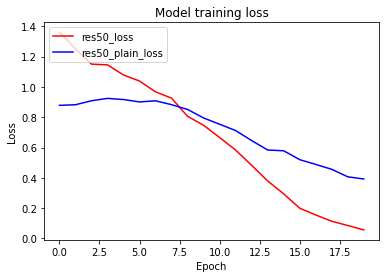

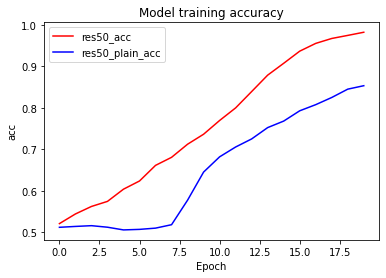

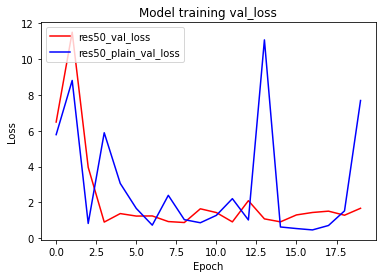

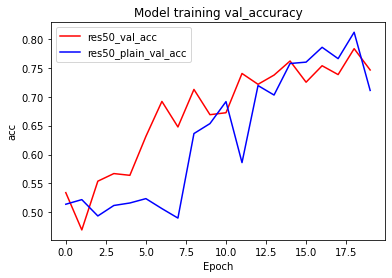

In [33]:
import matplotlib.pyplot as plt

plt.plot(his_res50.history['loss'], 'r')
plt.plot(his_res50_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['res50_loss','res50_plain_loss'], loc='upper left')
plt.show()
plt.plot(his_res50.history['accuracy'], 'r')
plt.plot(his_res50_plain.history['accuracy'], 'b')
plt.title('Model training accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['res50_acc','res50_plain_acc'], loc='upper left')
plt.show()
plt.plot(his_res50.history['val_loss'], 'r')
plt.plot(his_res50_plain.history['val_loss'], 'b')
plt.title('Model training val_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['res50_val_loss','res50_plain_val_loss'], loc='upper left')
plt.show()
plt.plot(his_res50.history['val_accuracy'], 'r')
plt.plot(his_res50_plain.history['val_accuracy'], 'b')
plt.title('Model training val_accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['res50_val_acc','res50_plain_val_acc'], loc='upper left')
plt.show()

# resnet_50(기본)과 resnet_plain_50 비교
학습진행을 보면 skip_connection이 없으면 전파가 아예 안되는 경우가 있어 진행이 안되다가  
갑자기 어느순간에는 오히려 skip_connection이 있는 것 보다 가파르게 오를 때도 있었지만  
validation을 보면 기본모델이 좀더 안정적으로 볼수있었다.

In [34]:
resnet30 = build_resnet(input_shape= (224,224,3),is_50 = False)
resnet30_plain = build_resnet(input_shape= (224,224,3),is_50 = False,plain= True)
resnet30.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],)
resnet30_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

In [35]:
his_res30_plain = resnet30_plain.fit(
    ds_train,
    steps_per_epoch= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.8),
    validation_steps= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.2),
    epochs = EPOCH,
    validation_data= ds_test,
    verbose= 1,
    use_multiprocessing= True,
)

Epoch 1/20
1163/1163 [==============================] - 122s 105ms/step - loss: 0.8422 - accuracy: 0.5126 - val_loss: 2.3086 - val_accuracy: 0.5136
Epoch 2/20
1163/1163 [==============================] - 106s 91ms/step - loss: 0.8164 - accuracy: 0.5182 - val_loss: 7.7757 - val_accuracy: 0.4901
Epoch 3/20
1163/1163 [==============================] - 106s 92ms/step - loss: 0.7975 - accuracy: 0.5291 - val_loss: 1.2175 - val_accuracy: 0.5127
Epoch 4/20
1163/1163 [==============================] - 107s 92ms/step - loss: 0.7723 - accuracy: 0.5512 - val_loss: 0.7880 - val_accuracy: 0.5235
Epoch 5/20
1163/1163 [==============================] - 107s 92ms/step - loss: 0.7211 - accuracy: 0.6190 - val_loss: 1.2696 - val_accuracy: 0.5781
Epoch 6/20
1163/1163 [==============================] - 107s 92ms/step - loss: 0.6795 - accuracy: 0.6576 - val_loss: 1.2979 - val_accuracy: 0.6389
Epoch 7/20
1163/1163 [==============================] - 108s 92ms/step - loss: 0.6228 - accuracy: 0.7061 - val_loss: 

In [36]:
his_res30 = resnet30.fit(
    ds_train,
    steps_per_epoch= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.8),
    validation_steps= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.2),
    epochs = EPOCH,
    validation_data= ds_test,
    verbose= 1,
    use_multiprocessing= True,
)

Epoch 1/20
1163/1163 [==============================] - 110s 95ms/step - loss: 1.0843 - accuracy: 0.5619 - val_loss: 2.7129 - val_accuracy: 0.5289
Epoch 2/20
1163/1163 [==============================] - 105s 90ms/step - loss: 0.9525 - accuracy: 0.5977 - val_loss: 1.9900 - val_accuracy: 0.5511
Epoch 3/20
1163/1163 [==============================] - 101s 87ms/step - loss: 0.8427 - accuracy: 0.6411 - val_loss: 6.6520 - val_accuracy: 0.5435
Epoch 4/20
1163/1163 [==============================] - 101s 87ms/step - loss: 0.7222 - accuracy: 0.6932 - val_loss: 1.4104 - val_accuracy: 0.5985
Epoch 5/20
1163/1163 [==============================] - 101s 87ms/step - loss: 0.6142 - accuracy: 0.7400 - val_loss: 0.6888 - val_accuracy: 0.7065
Epoch 6/20
1163/1163 [==============================] - 101s 87ms/step - loss: 0.4699 - accuracy: 0.8016 - val_loss: 0.6527 - val_accuracy: 0.7366
Epoch 7/20
1163/1163 [==============================] - 101s 87ms/step - loss: 0.3572 - accuracy: 0.8562 - val_loss: 1

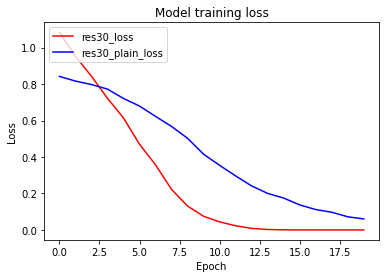

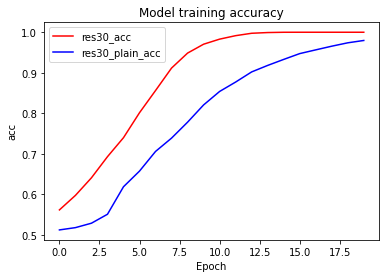

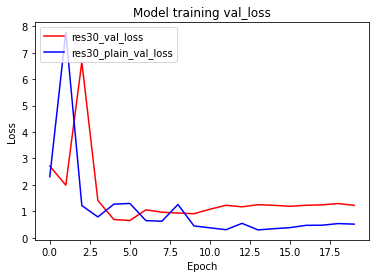

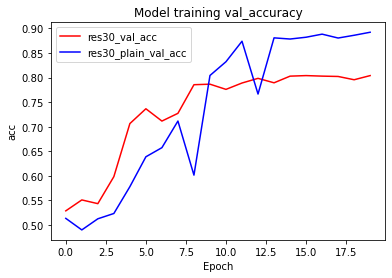

In [37]:
import matplotlib.pyplot as plt

plt.plot(his_res30.history['loss'], 'r')
plt.plot(his_res30_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['res30_loss','res30_plain_loss'], loc='upper left')
plt.show()
plt.plot(his_res30.history['accuracy'], 'r')
plt.plot(his_res30_plain.history['accuracy'], 'b')
plt.title('Model training accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['res30_acc','res30_plain_acc'], loc='upper left')
plt.show()
plt.plot(his_res30.history['val_loss'], 'r')
plt.plot(his_res30_plain.history['val_loss'], 'b')
plt.title('Model training val_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['res30_val_loss','res30_plain_val_loss'], loc='upper left')
plt.show()
plt.plot(his_res30.history['val_accuracy'], 'r')
plt.plot(his_res30_plain.history['val_accuracy'], 'b')
plt.title('Model training val_accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['res30_val_acc','res30_plain_val_acc'], loc='upper left')
plt.show()

# resnet34 비교 및 총평
믿기지 않은 결과가 나왔다. 벨리데이션 값이 오히려 skip_connetion이 없는 모델이 더 좋게 나왔다.  
34는 50에 비해 얕은 층이라고 할 수 있지만 충분히 역전파 소실이 일어날만한 깊이이다. 어째서 좋게 나왔는지 이해가 되지 않는다.  
50은 기본과 resnet의 차이가 validation_loss의 안정적 감소와 정확도 증가가 있었다.  
하지만 좀 더 얕은 층의 경우에서는 비록 조금 불안정하다 볼 순 있지만 훨씬 정확도 증가 측면에서 없는 것이 나았다.  
논문과 다르게 한 점은 batch_size밖에 없는데 이걸로 이런 결과가 나온다고 볼 수는 없다 생각이 들고,  
summary의 파라미터 수와 모델 이미지를 보았을 때 논문과 다른 점을 찾지 못하였고 resnet의 장점이 크게 와닿지 않았다.

